In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fb = pd.read_csv('fb_stock_prices_2018.csv', index_col='date', parse_dates=True)
quakes = pd.read_csv('earthquakes.csv')
covid = pd.read_csv('covid19_cases.csv').assign(
    date=lambda x: pd.to_datetime(x.dateRep, format='%d/%m/%Y')
).set_index('date').replace(
    'United_States_of_America', 'USA'
).sort_index()['2020-01-18':'2020-09-18']

Text(0.5, 1.01, 'Correlation between earthquake magnitude\nand whether there was a tsunami')

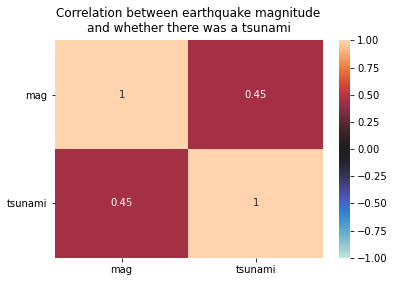

In [2]:
sns.heatmap(
    quakes.query('magType == "mb"')[['mag','tsunami']].corr(), 
    annot=True, center=0, vmin=-1, vmax=1
)
plt.yticks(rotation=0)
plt.title('Correlation between earthquake magnitude\nand whether there was a tsunami', y=1.01)

Text(0.5, 1.1, 'Facebook volume traded and closing price with Tukey Fence bounds')

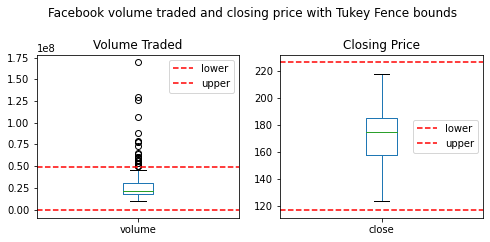

In [3]:
cols = ['volume', 'close']
subset = fb[cols]

quantiles = subset.quantile([0.25, 0.75])
quantiles.loc['iqr',:] = quantiles.loc[0.75,:] - quantiles.loc[0.25,:]

axes = subset.plot(kind='box', subplots=True, figsize=(8, 3), title=['Volume Traded', 'Closing Price'])
for ax, col in zip(axes, cols):
    stats = quantiles[col]
    lower = stats.loc[0.25] - 1.5 * stats['iqr']
    upper = stats.loc[0.75] + 1.5 * stats['iqr']
    for bound, name in zip([lower, upper], ['lower', 'upper']):
        ax.axhline(
            bound, 
            color='red', 
            linestyle='dashed',
            label=name
        )
        ax.legend()
plt.suptitle('Facebook volume traded and closing price with Tukey Fence bounds', y=1.1)

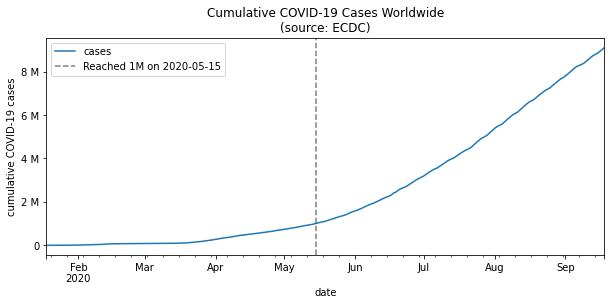

In [4]:
from matplotlib.ticker import EngFormatter

cumulative_cases = covid.groupby(pd.Grouper(freq='1D')).sum().cases.cumsum()

ax = cumulative_cases.plot(title='Cumulative COVID-19 Cases Worldwide\n(source: ECDC)', figsize=(10, 4))
ax.set_ylabel('cumulative COVID-19 cases')
ax.yaxis.set_major_formatter(EngFormatter())

over_1M = cumulative_cases[cumulative_cases >= 1e6].index[0]
ax.axvline(over_1M, linestyle='dashed', color='k', alpha=0.5, label=f"Reached 1M on {over_1M.strftime('%Y-%m-%d')}")

ax.legend()

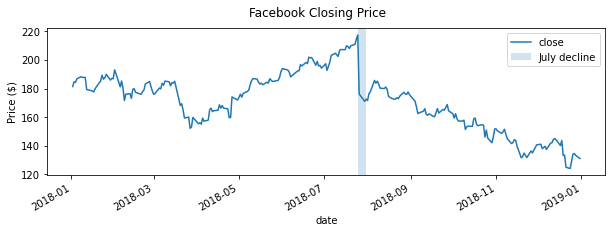

In [5]:
fb.close.plot(kind='line', figsize=(10, 3))
plt.axvspan(
    '2018-07-25', '2018-07-31', alpha=0.2, label='July decline',
)
plt.ylabel('Price ($)')
plt.suptitle('Facebook Closing Price')
plt.legend()

Text(0.5, 0.98, 'Facebook Closing Price')

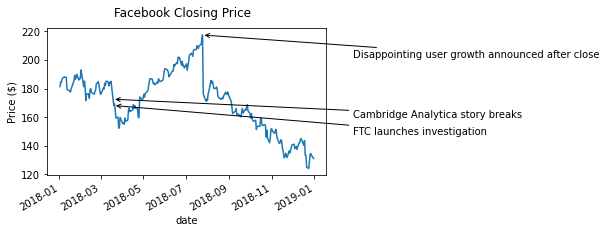

In [6]:
fb.close.plot(kind='line', figsize=(5, 3))

notes = [
    ('Disappointing user growth announced after close', '2018-07-25'),
    ('Cambridge Analytica story breaks', '2018-03-19'),
    ('FTC launches investigation', '2018-03-20')
]

# for repeatable random jitter
np.random.seed(1)

for text, date in notes:
    y_value = fb.close[date]
    jitter = np.random.uniform(-20, -10, 1)
    plt.annotate(
        text, 
        xy=(date, y_value),
        xytext=('2019-02-25', y_value + jitter),
        arrowprops=dict(arrowstyle='->')
    )
plt.ylabel('Price ($)')
plt.suptitle('Facebook Closing Price')

In [7]:
import itertools
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns


def reg_resid_plots(data):
    """
    Using `seaborn`, plot the regression and residuals
    plots side-by-side for every permutation of 2 columns 
    in the data.

    Parameters:
        - data: A `pandas.DataFrame` object

    Returns:
        A matplotlib `Axes` object.
    """
    num_cols = data.shape[1]
    permutation_count = num_cols * (num_cols - 1)

    fig, ax = plt.subplots(
        permutation_count, 
        2, 
        figsize=(15, 4 * permutation_count)
    )

    for (x, y), axes, color in zip(
        itertools.permutations(data.columns, 2), 
        ax,
        [cm.Dark2(i) for i in range(len(ax))]
    ):
        for subplot, func in zip(axes, (sns.regplot, sns.residplot)):
            func(x=x, y=y, data=data, ax=subplot, color=color)
            
            if func == sns.residplot:
                # mark the residuals as such
                subplot.set_ylabel('residuals')

    return fig.axes

[<AxesSubplot:xlabel='close', ylabel='volume'>,
 <AxesSubplot:xlabel='close', ylabel='residuals'>,
 <AxesSubplot:xlabel='volume', ylabel='close'>,
 <AxesSubplot:xlabel='volume', ylabel='residuals'>]

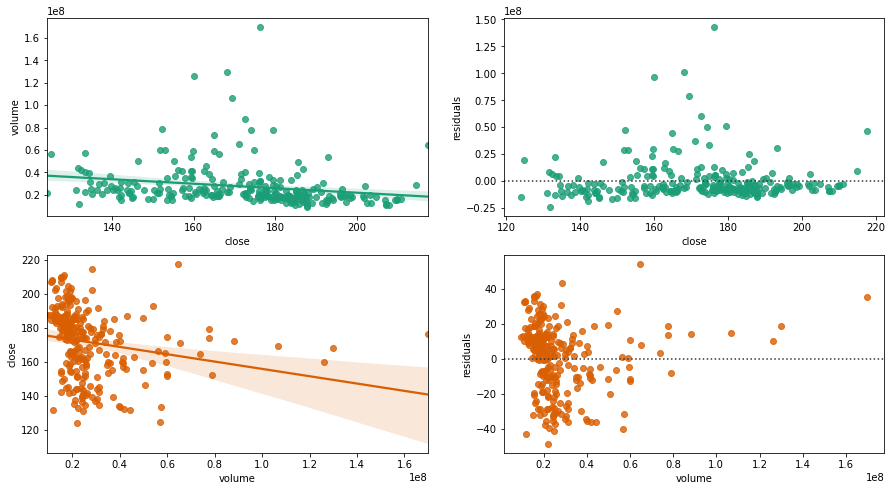

In [8]:
reg_resid_plots(fb[['close', 'volume']])